<a href="https://colab.research.google.com/github/sikoh/DS-Linear-Models/blob/main/Linear-Regression-2/DS_LinearRegression2_Lecture_Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries for R^2 visualization
from ipywidgets import interactive, IntSlider, FloatSlider
from math import floor, ceil
from sklearn.base import BaseEstimator, RegressorMixin

# Libraries for model building
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Library for working locally or Colab
import sys

In [ ]:
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'

# I. Wrangle Data

In [ ]:
 def wrangle(filepath):
  col_names = ['Year','incumbent','challenger', 'income', 'fatalities','incumbent_vote_share']
  df = pd.read_csv(DATA_PATH + 'elections/bread_peace_voting.csv',
                 #parse_dates = ['Year'],
                 names= col_names,
                 header=0,
                 index_col='Year')

  # Drop High Cardinality Columns
  cols_to_drop = []
  threshold = 10
  for col in df:
    if df[col].dtype == 'object':
      if df[col].nunique() > threshold:
        cols_to_drop.append(col)
  df.drop(columns= cols_to_drop, inplace=True)

  return df

In [ ]:
df = wrangle(DATA_PATH + 'elections/bread_peace_voting.csv')

In [ ]:
df.head()

,income,fatalities,incumbent_vote_share
Year,,,
1952,2.40,190,44.60
1956,2.89,0,57.76
1960,0.85,0,49.91
1964,4.21,1,61.34
1968,3.02,146,49.60


In [ ]:
df.shape

(17, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 1952 to 2016
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   income                17 non-null     float64
 1   fatalities            17 non-null     int64  
 2   incumbent_vote_share  17 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 544.0 bytes


In [ ]:
df

,income,fatalities,incumbent_vote_share
Year,,,
1952,2.40,190,44.60
1956,2.89,0,57.76
1960,0.85,0,49.91
1964,4.21,1,61.34
1968,3.02,146,49.60
1972,3.62,0,61.79
1976,1.08,2,48.95
1980,-0.39,0,44.70
1984,3.86,0,59.17


#Let's visualize the relationship between vote share and incomes; vote share and fatalities

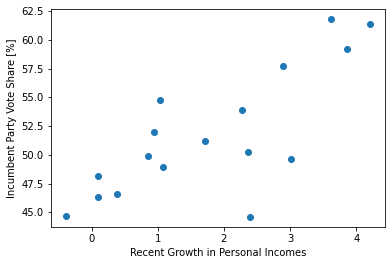

In [ ]:
plt.scatter(df['income'], df['incumbent_vote_share'])
plt.xlabel('Recent Growth in Personal Incomes')
plt.ylabel('Incumbent Party Vote Share [%]');

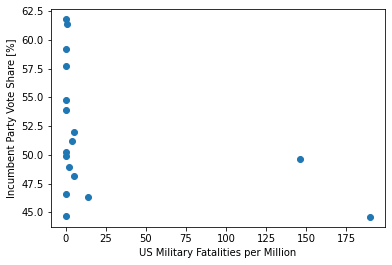

In [ ]:
plt.scatter(df['fatalities'], df['incumbent_vote_share'])
plt.xlabel('US Military Fatalities per Million')
plt.ylabel('Incumbent Party Vote Share [%]');

# II. Split Data

**First** we need to split our **target vector** from our **feature matrix**.

In [ ]:
# Define Feature X and Target y
target = 'incumbent_vote_share'
y = df[target]                   # Is one-Dimentional
X = df.drop(columns = target)    # Is Two-Dimentional

**Second** we need to split our dataset into **training** and **test** sets.

Two strategies:

- Random train-test split using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Generally we use 80% of the data for training, and 20% of the data for testing.
- If you have **timeseries**, then you need to do a "cutoff" split.

In [ ]:
# # Random train_test_split
# from sklearn.model_selection import train_test_split

# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
# Train data before 2004 and test data from 2004 - Present
cutoff = 2004
mask = X.index < 2004
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

In [ ]:
y_pred = [y_train.mean()] * len(y_train) #Use Training Data

print('Mean Incumbent Vote Share:', y_train.mean())
print(f'Baseline MAE: {mean_absolute_error(y_train, y_pred)}')

Mean Incumbent Vote Share: 52.56307692307692
Baseline MAE: 5.132544378698224


# IV. Build Model

In [ ]:
# Instanciate Your predictor
model = LinearRegression()

# Fit Model
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# V. Check Metrics

## Mean Absolute Error

The unit of measurement is the same as the unit of measurment for your target (in this case, vote share [%]).

In [ ]:
print('Training MAE:',mean_absolute_error(y_train, model.predict(X_train)))
print('Test MAE:',mean_absolute_error(y_test, model.predict(X_test)))

Training MAE: 1.3737002516876717
Test MAE: 1.4133453705003944


## Root Mean Squared Error

The unit of measurement is the same as the unit of measurment for your target (in this case, vote share [%]).

In [ ]:
print('Training RMSE:',mean_squared_error(y_train, model.predict(X_train), squared=False))
print('Test RMSE:',mean_squared_error(y_test, model.predict(X_test), squared=False))

Training RMSE: 2.0376005753896838
Test RMSE: 1.623765003537601


## $R^2$ Score

TL;DR: Usually ranges between 0 (bad) and 1 (good).

In [ ]:
class BruteForceRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, m=0, b=0):
        self.m = m
        self.b = b
        self.mean = 0

    def fit(self, X, y):
        self.mean = np.mean(y)
        return self

    def predict(self, X, return_mean=True):
        if return_mean:
            return [self.mean] * len(X)
        else:
            return X * self.m + self.b

def plot(slope, intercept):
    # Assign data to variables
    x = df['income']
    y = df['incumbent_vote_share']

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

    # Set ax limits
    mar = 0.2
    x_lim = floor(x.min() - x.min()*mar), ceil(x.max() + x.min()*mar)
    y_lim = floor(y.min() - y.min()*mar), ceil(y.max() + y.min()*mar)

    # Instantiate and train model
    bfr = BruteForceRegressor(slope, intercept)
    bfr.fit(x, y)

    # ax1
    ## Plot data
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    ax1.scatter(x, y)

    ## Plot base model
    ax1.axhline(bfr.mean, color='orange', label='baseline model')

    ## Plot residual lines
    y_base_pred = bfr.predict(x)
    ss_base = mean_squared_error(y, y_base_pred) * len(y)
    for x_i, y_i, yp_i in zip(x, y, y_base_pred):
        ax1.plot([x_i, x_i], [y_i, yp_i],
                 color='gray', linestyle='--', alpha=0.75)

    ## Formatting
    ax1.legend()
    ax1.set_title(f'Sum of Squares: {np.round(ss_base, 2)}')
    ax1.set_xlabel('Growth in Personal Incomes')
    ax1.set_ylabel('Incumbent Party Vote Share [%]')

    # ax2

    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)
    ## Plot data
    ax2.scatter(x, y)

    ## Plot model
    x_model = np.linspace(*ax2.get_xlim(), 10)
    y_model = bfr.predict(x_model, return_mean=False)
    ax2.plot(x_model, y_model, color='green', label='our model')
    for x_coord, y_coord in zip(x, y):
        ax2.plot([x_coord, x_coord], [y_coord, x_coord * slope + intercept],
                 color='gray', linestyle='--', alpha=0.75)

    ss_ours = mean_squared_error(y, bfr.predict(x, return_mean=False)) * len(y)

    ## Formatting
    ax2.legend()
    ax2.set_title(f'Sum of Squares: {np.round(ss_ours, 2)}')
    ax2.set_xlabel('Growth in Personal Incomes')
    ax2.set_ylabel('Incumbent Party Vote Share [%]')

y = df['incumbent_vote_share']
slope_slider = FloatSlider(min=-5, max=5, step=0.5, value=0)
intercept_slider = FloatSlider(min=int(y.min()), max=y.max(), step=2, value=y.mean())

interactive(plot, slope=slope_slider, intercept=intercept_slider)

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0, step=0.5), FloatSlider(va…

# VI. Communicate Results

**Challenge:** How can we find the coefficients and intercept for our `model`?

In [ ]:
model.coef_
#model.intercept_

46.36824118234689

In [ ]:
print('The coefficient for income is:', model.coef_[0])
print('The coefficient for fatalities is:', model.coef_[1])

The coefficient for income is: 3.5769044691079976
The coefficient for fatalities is: -0.05355141496518978


In [ ]:
print('The intercept of our model is:', model.intercept_)

The intercept of our model is: 46.36824118234689
